# Neural Network Classifier with MNIST


## Libraries

In [1]:
# libraries
#using Flux              # the julia ml library
using Images            # image processing and machine vision for julia
using MLJ               # make_blobs, rmse, confmat, f1score, coerce
using MLJFlux           # NeuralNetworkClassifier, CUDALibs
using MLDataUtils       # label, nlabel, labelfreq
using MLDatasets        # mnist

#using LinearAlgebra     # pinv pseudo-inverse matrix
#using Metrics           # r2-score
using Random
using StatsBase         # standardize (normalization)
#using Distributions

using Plots; gr()
#using StatsPlots
using Printf

#using CSV
using DataFrames


## Functions

In [2]:
# metrics
function printMetrics(ŷ, y)
    display(confmat(ŷ, y))
    println("accuracy: ", round(accuracy(ŷ, y); digits=3))
    println("f1-score: ", round(multiclass_f1score(ŷ, y); digits=3))
end


printMetrics (generic function with 1 method)

In [3]:
# lib functions
image2Vector(M) = vec(Float64.(M))

function batchImage2Vector(imagesArray3D)
    h, v, N = size(imagesArray3D)
    vectorOfImageVectors = [ image2Vector( imagesArray3D[:, :, i] ) for i in 1:N]
end

function batchImage2DF(imagesArray3D)
    vectorOfImageVectors = batchImage2Vector(imagesArray3D)
    M = reduce(hcat, vectorOfImageVectors)
    DataFrame(M', :auto)
end


batchImage2DF (generic function with 1 method)

## Loading the data

,,,,

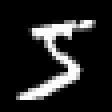
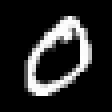
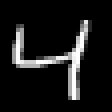
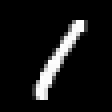
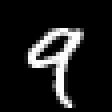

1×5 adjoint(::Vector{Int64}) with eltype Int64:
 5  0  4  1  9

In [4]:
# load mnist from MLDatasets
trainX_original,      trainY_original      = MNIST.traindata()
validationX_original, validationY_original = MNIST.testdata();

display([MNIST.convert2image(MNIST.traintensor(i)) for i in 1:5])
trainY_original[1:5]'

In [5]:
# split trainset, testset, validation set
Random.seed!(1)
(trainX, trainY), (testX, testY) = stratifiedobs((trainX_original, trainY_original), p = 0.7)
validationX = copy(validationX_original); validationY = copy(validationY_original)

size(trainX), size(testX), size(validationX)

((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

## Data preprocessing

Data preprocessing depends on the data source, thus can widely vary from what is shown here.

In [6]:
function preprocessing(X, y)
    newX = batchImage2DF(X)
    #coerce!(newX)   # no need, all scitypes are Continuous in this example
    new_y = coerce(y, OrderedFactor)
    
    return (newX, new_y)
end

X, y = preprocessing(trainX, trainY);

In [7]:
scitype(X)

Table{AbstractVector{Continuous}}

In [8]:
scitype(y)

AbstractVector{OrderedFactor{10}} (alias for AbstractArray{OrderedFactor{10}, 1})

## Training, Testing, Validation

### Load the algorithm

In [9]:
NeuralNetworkClassifier = @load NeuralNetworkClassifier pkg=MLJFlux verbosity=0

MLJFlux.NeuralNetworkClassifier

### Instantiate the model


In [10]:
model = NeuralNetworkClassifier(acceleration=CUDALibs())

NeuralNetworkClassifier(
    builder = Short(
            n_hidden = 0,
            dropout = 0.5,
            σ = NNlib.σ),
    finaliser = NNlib.softmax,
    optimiser = Flux.Optimise.ADAM(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}()),
    loss = Flux.Losses.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    rng = Random._GLOBAL_RNG(),
    optimiser_changes_trigger_retraining = false,
    acceleration = CUDALibs{Nothing}(nothing))

### Create and train the machine


In [11]:
mach = MLJ.machine(model, X, y)

Machine{NeuralNetworkClassifier{Short,…},…} trained 0 times; caches data
  model: MLJFlux.NeuralNetworkClassifier{MLJFlux.Short, typeof(NNlib.softmax), Flux.Optimise.ADAM, typeof(Flux.Losses.crossentropy)}
  args: 
    1:	Source @447 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @020 ⏎ `AbstractVector{OrderedFactor{10}}`


In [17]:
fit!(mach, verbosity=2)

┌ Info: Updating Machine{NeuralNetworkClassifier{Short,…},…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/CglMw/src/machines.jl:465
┌ Info: Loss is 0.279
└ @ MLJFlux /home/ciro/.julia/packages/MLJFlux/ex3rh/src/core.jl:127
┌ Info: Loss is 0.2466
└ @ MLJFlux /home/ciro/.julia/packages/MLJFlux/ex3rh/src/core.jl:127
┌ Info: Loss is 0.2264
└ @ MLJFlux /home/ciro/.julia/packages/MLJFlux/ex3rh/src/core.jl:127
┌ Info: Loss is 0.2205
└ @ MLJFlux /home/ciro/.julia/packages/MLJFlux/ex3rh/src/core.jl:127
┌ Info: Loss is 0.2155
└ @ MLJFlux /home/ciro/.julia/packages/MLJFlux/ex3rh/src/core.jl:127
┌ Info: Loss is 0.2022
└ @ MLJFlux /home/ciro/.julia/packages/MLJFlux/ex3rh/src/core.jl:127
┌ Info: Loss is 0.2018
└ @ MLJFlux /home/ciro/.julia/packages/MLJFlux/ex3rh/src/core.jl:127
┌ Info: Loss is 0.1962
└ @ MLJFlux /home/ciro/.julia/packages/MLJFlux/ex3rh/src/core.jl:127
┌ Info: Loss is 0.1891
└ @ MLJFlux /home/ciro/.julia/packages/MLJFlux/ex3rh/src/core.jl:127


Machine{NeuralNetworkClassifier{Short,…},…} trained 2 times; caches data
  model: MLJFlux.NeuralNetworkClassifier{MLJFlux.Short, typeof(NNlib.softmax), Flux.Optimise.ADAM, typeof(Flux.Losses.crossentropy)}
  args: 
    1:	Source @447 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @020 ⏎ `AbstractVector{OrderedFactor{10}}`


In [18]:
fitted_params(mach)

(chain = Chain(Chain(Dense(784, 89, σ), Dropout(0.5), Dense(89, 10)), softmax),)

In [19]:
report(mach)

(training_losses = Float32[2.4227393, 0.1912836, 0.2790494, 0.24664894, 0.22637433, 0.22045232, 0.21548657, 0.20220548, 0.20180218, 0.19617553, 0.18911059],)

### Predict the outcome


In [20]:
ŷ = predict_mode(mach, X)
ŷ[1:5]

5-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 8
 2
 6
 2
 7

In [21]:
printMetrics(ŷ, y)

10×10 Matrix{Int64}:
 4105     1     4     4     3     5     8     5     8    13
    0  4639     2     1     5     0     1     5    18     1
    8    29  4121    74    11     8     4    21    40     5
    1    14     5  4116     0    23     1     3    19    20
    6     4     9     0  3988     3     5     5     6    49
    4     3     6    39     1  3708    18     2    39    12
   14     3     4     5    19    25  4103     0    13     1
    0     8    15    32    13     4     0  4340     6    84
    8    15     5    11     2    12     3     2  3927     8
    0     3     0    10    47     7     0     3    20  3971

accuracy: 0.977
f1-score: 0.976


### Tune the hyper-parameters

When this particular model was instantiated above, one can see that the hyper-parameter "Lambda" could be of relevance to improve the model. Let's tune it as an attempt to minimize the cross-entropy loss and maximize accuracy.

First, we define the parameter and limits to scan:

Then, we define a 10-fold cross-validation, and capture the range parameter(lambdas) and the cross-entropy losses vectors (losses). The first two parameters of the tuple out of the function "learning_curve" are not relevent for this example, so are ignored:

As seen on the chart above, the best tuning parameter is:

### Retrain with best tuning parameter

(in progress)

### Evaluate

(in progress)

### Testing

### Validation